# Analyse des données BTC/USD
# TFT = Temporal Fusion Transformer
---
## 1. Chargement des données

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, Add, Input, Activation, BatchNormalization
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import datetime
import matplotlib.dates as mdates

df = pd.read_csv('../data/btcusd_1-min_data.csv')

# convert to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')

print(f"Nb lines: {len(df)}")
print(df.head())
print(df.info())

Nb lines: 7258717
            Timestamp  Open  High   Low  Close  Volume
0 2012-01-01 10:01:00  4.58  4.58  4.58   4.58     0.0
1 2012-01-01 10:02:00  4.58  4.58  4.58   4.58     0.0
2 2012-01-01 10:03:00  4.58  4.58  4.58   4.58     0.0
3 2012-01-01 10:04:00  4.58  4.58  4.58   4.58     0.0
4 2012-01-01 10:05:00  4.58  4.58  4.58   4.58     0.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7258717 entries, 0 to 7258716
Data columns (total 6 columns):
 #   Column     Dtype         
---  ------     -----         
 0   Timestamp  datetime64[ns]
 1   Open       float64       
 2   High       float64       
 3   Low        float64       
 4   Close      float64       
 5   Volume     float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 332.3 MB
None


---
## 2. Visualisation du prix en fonction du temps

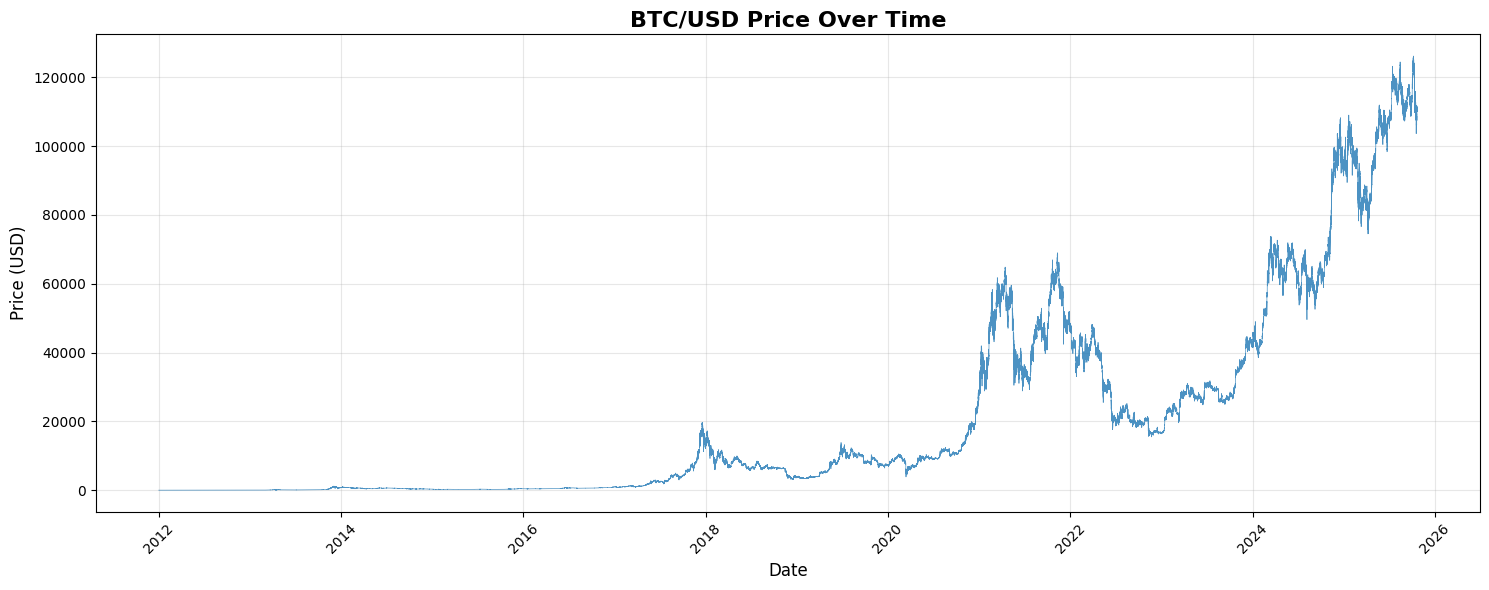

min price: $3.8
max price: $126202.0
mean: $20605.617259248593
std dev: $29161.716912376545


In [22]:
# plot
plt.figure(figsize=(15, 6))
plt.plot(df['Timestamp'], df['Close'], linewidth=0.5, alpha=0.8)
plt.title('BTC/USD Price Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('images/01_btc_price_history_tft.png', dpi=100, bbox_inches='tight')
plt.show()

# stats
print(f"min price: ${df['Close'].min()}")
print(f"max price: ${df['Close'].max()}")
print(f"mean: ${df['Close'].mean()}")
print(f"std dev: ${df['Close'].std()}")

---
## 3. Préparation des données pour LSTM

In [23]:
# Increase to 20000 values for Very Deep Learning
data = df['Close'].values[-20000:].reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

print(f"data shape: {scaled_data.shape}")
print(f"min {scaled_data.min()}, max {scaled_data.max()}")

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Increase seq_length from 60 to 120
seq_length = 120
X, y = create_sequences(scaled_data, seq_length)

X = X.reshape(X.shape[0], X.shape[1], 1)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"\ntraining shape {X_train.shape}")
print(f"test shape {X_test.shape}")

data shape: (20000, 1)
min 0.0, max 1.0

training shape (15904, 120, 1)
test shape (3976, 120, 1)


---
## 4. Construction du modèle TFT

In [24]:
# VERSION TFT (Temporal Fusion Transformer) pour séries temporelles

import tensorflow as tf
import numpy as np

d_model = 64
num_heads = 8
dff = 256
num_layers = 2
dropout_rate = 0.2
l2_reg = 0.0001


def positional_encoding(position, d_model):
    angle_rads = np.arange(position)[:, np.newaxis] / np.power(
        10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model)
    )
    sines = np.sin(angle_rads[:, 0::2])
    cosines = np.cos(angle_rads[:, 1::2])
    pos_encoding = np.zeros(angle_rads.shape)
    pos_encoding[:, 0::2] = sines
    pos_encoding[:, 1::2] = cosines
    return tf.cast(pos_encoding[np.newaxis, ...], dtype=tf.float32)

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        self.num_heads = num_heads
        self.depth = d_model // num_heads
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        q = self.split_heads(self.wq(q), batch_size)
        k = self.split_heads(self.wk(k), batch_size)
        v = self.split_heads(self.wv(v), batch_size)
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
        if mask is not None:
            scaled_attention_logits += (mask * -1e9)
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        output = tf.matmul(attention_weights, v)
        output = tf.transpose(output, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(output, (batch_size, -1, self.num_heads * self.depth))
        return self.dense(concat_attention)

def point_wise_ffn(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.3):
        super().__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_ffn(d_model, dff)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training=False, mask=None):
        attn_output = self.mha(x, x, x, mask)
        out1 = self.norm1(x + self.dropout1(attn_output, training=training))
        ffn_output = self.ffn(out1)
        out2 = self.norm2(out1 + self.dropout2(ffn_output, training=training))
        return out2

class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, maximum_position_encoding, rate=0.3):
        super().__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training=False, mask=None):
        seq_len = tf.shape(x)[1]
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training=training, mask=mask)
        return x

class TemporalFusionTransformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, seq_length, rate=0.2):
        super().__init__()
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, seq_length, rate)
        self.fc_layers = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
            tf.keras.layers.Dropout(rate),
            tf.keras.layers.Dense(dff // 2, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
            tf.keras.layers.Dropout(rate),
            tf.keras.layers.Dense(1)
        ])

    def call(self, inp, training=False, mask=None):
        enc_output = self.encoder(inp, training=training, mask=mask)
        last_output = enc_output[:, -1, :]
        return self.fc_layers(last_output, training=training)


# Créer le modèle TFT
tft_model = TemporalFusionTransformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    seq_length=seq_length,
    rate=dropout_rate
)

input_layer = tf.keras.Input(shape=(seq_length, 1))
output = tft_model(input_layer, training=False, mask=None)
final_model = tf.keras.Model(inputs=input_layer, outputs=output)

# Optimizer meilleur
final_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mae']
)

final_model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 120, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ temporal_fusion_transformer_3   │ (None, 1)              │       149,633 │
│ (TemporalFusionTransformer)     │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 149,633 (584.50 KB)

 Trainable params: 149,633 (584.50 KB)

 Non-trainable params: 0 (0.00 B)

---
## 5. Entraînement du modèle

In [25]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    TensorBoard(
        log_dir=log_dir,
        histogram_freq=1
    ),
    ModelCheckpoint(
        filepath='best_tft_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

# Entraînement
history = final_model.fit(
    X_train, y_train,
    batch_size=64,
    epochs=100,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Evolution')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE Evolution')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/02_training_history_tft.png', dpi=100, bbox_inches='tight')
plt.show()

Epoch 1/100
223/224 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1556 - mae: 0.2662
Epoch 1: val_loss improved from None to 0.02749, saving model to best_tft_model.keras
224/224 ━━━━━━━━━━━━━━━━━━━━ 18s 66ms/step - loss: 0.0950 - mae: 0.2065 - val_loss: 0.0275 - val_mae: 0.0454 - learning_rate: 0.0010
Epoch 2/100
223/224 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0434 - mae: 0.1087
Epoch 2: val_loss improved from 0.02749 to 0.02313, saving model to best_tft_model.keras
224/224 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - loss: 0.0392 - mae: 0.0976 - val_loss: 0.0231 - val_mae: 0.0285 - learning_rate: 0.0010
Epoch 3/100
223/224 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0317 - mae: 0.0781
Epoch 3: val_loss improved from 0.02313 to 0.02145, saving model to best_tft_model.keras
224/224 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - loss: 0.0305 - mae: 0.0756 - val_loss: 0.0214 - val_mae: 0.0354 - learning_rate: 0.0010
Epoch 4/100
223/224 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0269 - mae: 0.0674
Epoch

KeyboardInterrupt: 

---
## 6. Prédictions et évaluation

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
MSE: $3738621.987143565
MAE: $1770.6356498365192
RMSE: $1933.5516510151895
R2 Score: -0.3096163501520546
MSE: $3738621.987143565
MAE: $1770.6356498365192
RMSE: $1933.5516510151895
R2 Score: -0.3096163501520546


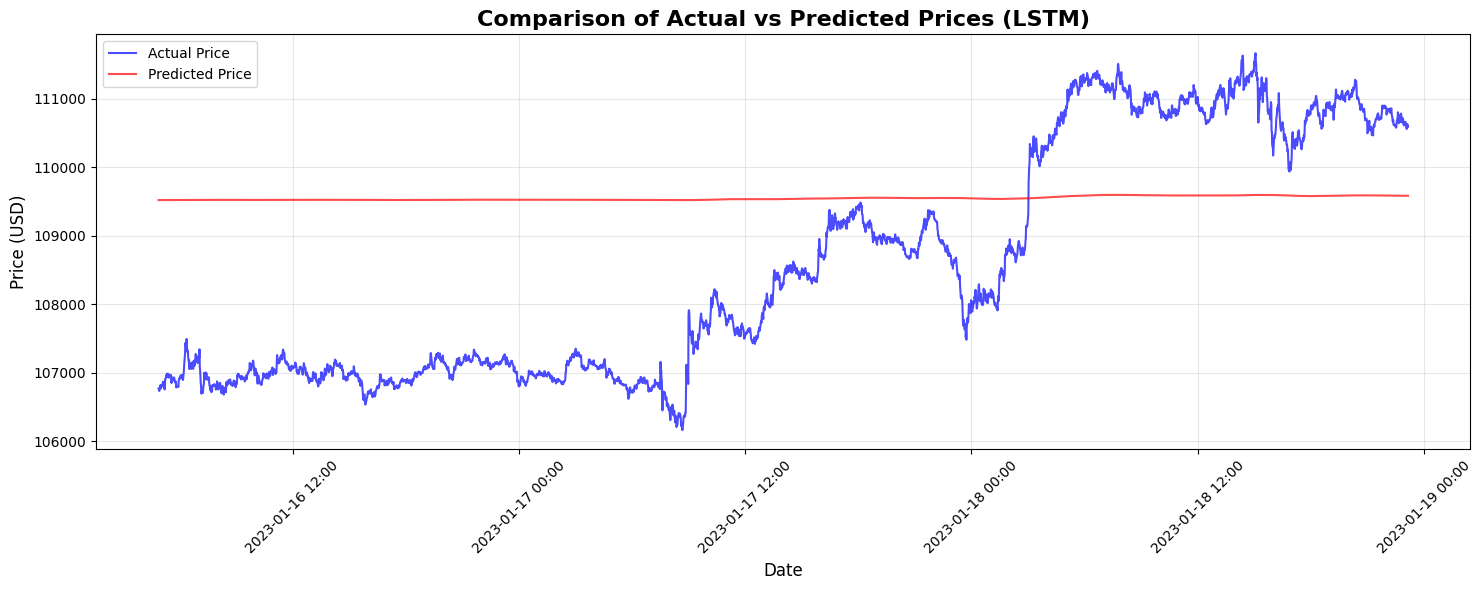

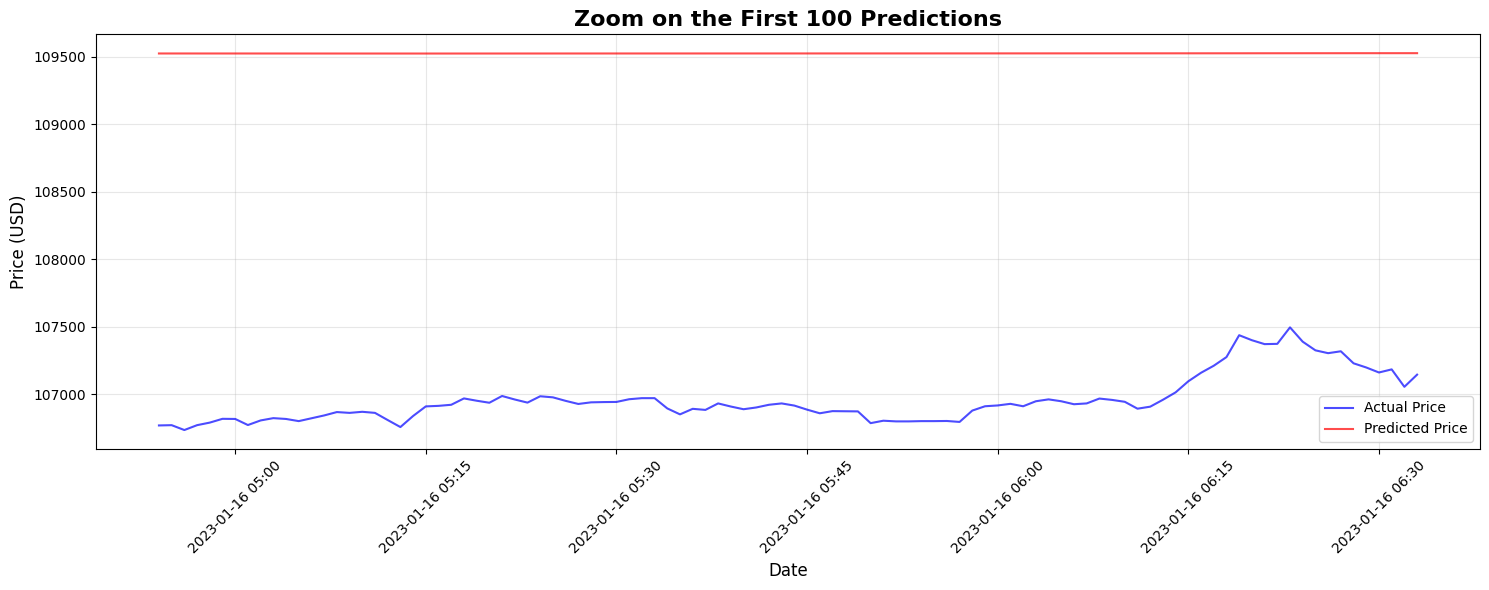

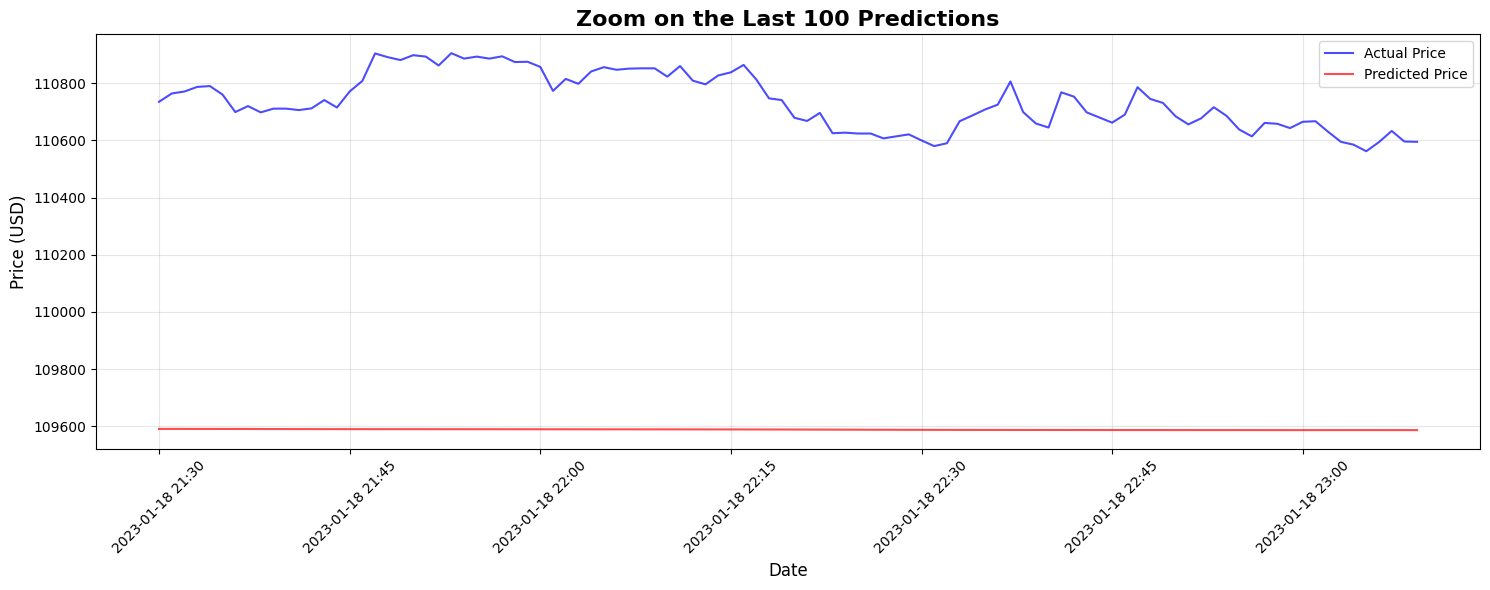

In [ ]:
predictions = final_model.predict(X_test)

predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Get timestamps for test data (correspondant aux prédictions)
test_start_idx = int(0.8 * len(df)) + seq_length + seq_length
test_timestamps = df['Timestamp'].iloc[test_start_idx:test_start_idx + len(predictions)].values

mse = mean_squared_error(y_test_actual, predictions)
mae = mean_absolute_error(y_test_actual, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, predictions)

print(f"MSE: ${mse}")
print(f"MAE: ${mae}")
print(f"RMSE: ${rmse}")
print(f"R2 Score: {r2}")

# Full predictions with dates
plt.figure(figsize=(15, 6))
plt.plot(test_timestamps, y_test_actual, label='Actual Price', color='blue', alpha=0.7)
plt.plot(test_timestamps, predictions, label='Predicted Price', color='red', alpha=0.7)
plt.title('Comparison of Actual vs Predicted Prices (LSTM)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('images/03_predictions_full_tft.png', dpi=100, bbox_inches='tight')
plt.show()

# Zoom first 100
plt.figure(figsize=(15, 6))
plt.plot(test_timestamps[:100], y_test_actual[:100], label='Actual Price', color='blue', alpha=0.7)
plt.plot(test_timestamps[:100], predictions[:100], label='Predicted Price', color='red', alpha=0.7)
plt.title('Zoom on the First 100 Predictions', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('images/04_predictions_first_100_tft.png', dpi=100, bbox_inches='tight')
plt.show()

# Zoom last 100
plt.figure(figsize=(15, 6))
plt.plot(test_timestamps[-100:], y_test_actual[-100:], label='Actual Price', color='blue', alpha=0.7)
plt.plot(test_timestamps[-100:], predictions[-100:], label='Predicted Price', color='red', alpha=0.7)
plt.title('Zoom on the Last 100 Predictions', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('images/05_predictions_last_100_tft.png', dpi=100, bbox_inches='tight')
plt.show()

---
## 7. Visualisation avec TensorBoard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6007 (pid 14496), started 0:29:52 ago. (Use '!kill 14496' to kill it.)